In [1]:
import os
from pathlib import Path
from tqdm import tqdm
import pickle

from qiskit import transpile
from qiskit.circuit.random import random_circuit
from qiskit.providers.fake_provider import FakeLimaV2
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import BackendEstimator, Estimator

from tqdm import tqdm

from blackwater.data.utils import get_backend_properties_v1, encode_pauli_sum_op
from blackwater.exception import BlackwaterException

from qiskit import QuantumCircuit, transpile
from qiskit.opflow import PauliSumOp
from qiskit.primitives import BaseEstimator, EstimatorResult
from qiskit.providers import JobV1 as Job, Options, BackendV2, Backend, BackendV1
from qiskit.quantum_info import SparsePauliOp
from qiskit.providers.fake_provider import FakeLimaV2, FakeLima, ConfigurableFakeBackend
from qiskit.opflow import I, X, Z, Y
from qiskit.algorithms.minimum_eigensolvers import VQE, VQEResult
from qiskit.algorithms.optimizers import SLSQP, SPSA, COBYLA
from qiskit.circuit.library import TwoLocal

from blackwater.data.utils import generate_random_pauli_sum_op, get_backend_properties_v1
from blackwater.library.learning.estimator import learning, EmptyProcessor, TorchLearningModelProcessor, ScikitLearningModelProcessor
from qiskit_aer import AerSimulator, QasmSimulator
import itertools
import numpy as np
from mbd_utils import cal_all_z_exp

from mlp import encode_data, MLP1
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
import random

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from qiskit.quantum_info import Operator

from qiskit.result import marginal_counts
from qiskit import execute
from qiskit_aer import QasmSimulator

In [2]:
qasm_sim = QasmSimulator()

backend = FakeLima()
properties = get_backend_properties_v1(backend)

backend_ideal = QasmSimulator() # Noiseless
backend_noisy = AerSimulator.from_backend(backend) # Noisy

run_config_ideal = {'shots': 10000, 'backend': backend_ideal, 'name': 'ideal'}
run_config_noisy = {'shots': 10000, 'backend': backend_noisy, 'name': 'noisy'}

NUM_QUBITS = 2

In [3]:
def fix_random_seed(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    print(f'random seed fixed to {seed}')

In [4]:
def get_all_z_exp_wo_shot_noise(circuit, marginal_over=None):
    circuit_copy = circuit.copy()
    circuit_copy.remove_final_measurements()
    circuit_copy.save_density_matrix()

    def int_to_bin(n, num_bits=4):
        if n < 2 ** num_bits:
            binary_str = bin(n)[2:]
            return binary_str.zfill(num_bits)
        else:
            raise ValueError

    circuit_copy = transpile(circuit_copy, backend=backend_noisy, optimization_level=3)
    job = qasm_sim.run(circuit_copy)
    # job = execute(circuit_copy, QasmSimulator(), backend_options={'method': 'statevector'})
    probs = np.real(np.diag(job.result().results[0].data.density_matrix))
    probs = {int_to_bin(i, num_bits=NUM_QUBITS): p for i, p in enumerate(probs)}

    if marginal_over:
        probs = marginal_counts(probs, indices=marginal_over)

    exp_val = 0
    for key, prob in probs.items():
        num_ones = key.count('1')
        exp_val += (-1) ** num_ones * prob

    return exp_val

In [5]:
def load_circuits(data_dir, f_ext='.json', specific_file=None):
    circuits = []
    trans_circuits = []
    ideal_exp_vals = []
    noisy_exp_vals = []
    meas_basis = []
    data_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(f_ext)] if specific_file is None else [specific_file]
    for data_file in tqdm(data_files, leave=True):
        if f_ext == '.json':
            for entry in json.load(open(data_file, 'r')):
                circuits.append(QuantumCircuit.from_qasm_str(entry['circuit']))
                ideal_exp_vals.append(entry['ideal_exp_value'])
                noisy_exp_vals.append(entry['noisy_exp_values'])
        elif f_ext == '.pk':
            for entry in pickle.load(open(data_file, 'rb')):
                circuits.append(entry['circuit'])
                trans_circuits.append(entry['trans_circuit'])
                ideal_exp_vals.append(entry['ideal_exp_value'])
                noisy_exp_vals.append(entry['noisy_exp_values'])
                meas_basis.append(entry['meas_basis'])
    return trans_circuits, ideal_exp_vals, noisy_exp_vals, meas_basis

In [6]:
circuits, ideal_exp_vals, noisy_exp_vals, meas_bases = load_circuits('./data/vqe/', '.pk', specific_file='./data/vqe/two_local_2q_3reps_oplev0_rycz.pk')
print(len(circuits))

sep = 2999
train_circuits, train_ideal_exp_vals, train_noisy_exp_vals, train_meas_bases = circuits[:sep], ideal_exp_vals[:sep], \
    noisy_exp_vals[:sep], meas_bases[:sep]
test_circuits, test_ideal_exp_vals, test_noisy_exp_vals, test_meas_bases = circuits[sep:], ideal_exp_vals[sep:], \
    noisy_exp_vals[sep:], meas_bases[sep:]
print(len(train_circuits))

100%|██████████| 1/1 [00:02<00:00,  2.05s/it]

3000
2999


In [7]:
encode_pauli_sum_op(0.2 * SparsePauliOp('XX'))

[[0.2, 0, 0, 0, 1, 0, 0, 0, 1]]

In [8]:
train_observables = [encode_pauli_sum_op(SparsePauliOp(basis))[0] for basis in train_meas_bases]
test_observables = [encode_pauli_sum_op(SparsePauliOp(basis))[0] for basis in test_meas_bases]
X_train, y_train = encode_data(train_circuits, properties, train_ideal_exp_vals, train_noisy_exp_vals, num_qubits=1,
                               meas_bases=train_observables)
X_test, y_test = encode_data(test_circuits, properties, test_ideal_exp_vals, test_noisy_exp_vals, num_qubits=1,
                             meas_bases=test_observables)

print(len(X_test[0]), 54 + 1 + len(test_observables[0]))

BATCH_SIZE = 32
fix_random_seed(0)
test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE * 1000, shuffle=False)

print(train_circuits[0].count_ops())

64 64
random seed fixed to 0
OrderedDict([('rz', 36), ('sx', 22), ('cx', 3)])


In [9]:
print(train_circuits[0].count_ops())
# train_circuits[0].decompose().draw('mpl', fold=-1, idle_wires=False)

OrderedDict([('rz', 36), ('sx', 22), ('cx', 3)])


In [10]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
rfr = RandomForestRegressor(n_estimators=300)
rfr.fit(X_train, y_train)

/var/folders/kj/mfqyg_tj77nf4gt67lvscdkw0000gn/T/ipykernel_99921/963820048.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr.fit(X_train, y_train)


RandomForestRegressor(n_estimators=300)

random seed fixed to 0
RMSE_noisy_0: 0.0020568668842315674
RMSE_mitigated_0: 0.017757565627495475
RMSE_noisy: 0.0020568668842315674
RMSE_mitigated: 0.017757565627495475


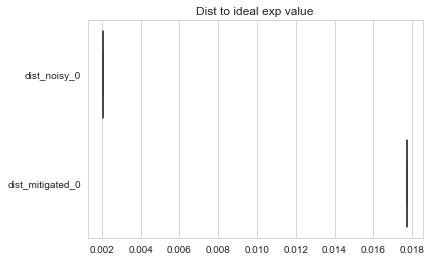

In [11]:
fix_random_seed(0)

distances = []

num_spins = 1

for batch_X, batch_y in test_loader:
    out = rfr.predict(batch_X)

    for ideal, noisy, ngm_mitigated in zip(
        batch_y.tolist(),
        batch_X[:, 54].tolist(),
        out.tolist()
    ):
        for q in range(num_spins):
            ideal_q = ideal[q]
            noisy_q = noisy
            ngm_mitigated_q = ngm_mitigated
            distances.append({
                "num_train_samples": sep,
                f"ideal_{q}": ideal_q,
                f"noisy_{q}": noisy_q,
                f"ngm_mitigated_{q}": ngm_mitigated_q,
                f"dist_noisy_{q}": np.abs(ideal_q - noisy_q),
                f"dist_mitigated_{q}": np.abs(ideal_q - ngm_mitigated_q),
                f"dist_sq_noisy_{q}": np.square(ideal_q - noisy_q),
                f"dist_sq_mitigated_{q}": np.square(ideal_q - ngm_mitigated_q),
            })

plt.style.use({'figure.facecolor':'white'})

df = pd.DataFrame(distances)

for q in range(num_spins):
    print(f'RMSE_noisy_{q}:', np.sqrt(df[f"dist_sq_noisy_{q}"].mean()))
    print(f'RMSE_mitigated_{q}:', np.sqrt(df[f"dist_sq_mitigated_{q}"].mean()))

print(f'RMSE_noisy:', np.sqrt(np.mean([df[f"dist_sq_noisy_{q}"].mean() for q in range(num_spins)])))
print(f'RMSE_mitigated:', np.sqrt(np.mean([df[f"dist_sq_mitigated_{q}"].mean() for q in range(num_spins)])))

sns.boxplot(data=df[["dist_noisy_0", "dist_mitigated_0"]], orient="h", showfliers = False)
plt.title("Dist to ideal exp value")
plt.show()

# sns.histplot([df['ideal_0'], df['noisy_0'], df["ngm_mitigated_0"]], kde=True, bins=40)
# plt.title("Exp values distribution")
# # plt.xlim([-0.2, 0.2])
# plt.show()

In [12]:
# from qiskit.quantum_info import Operator
# qc = QuantumCircuit(2)
# qc.x(0)
# qc.id(1)
# Operator(qc)

In [13]:
# (I ^ X).to_matrix()

8
OrderedDict([('TwoLocal', 1)])


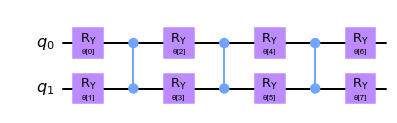

In [15]:
np.random.seed(0)
ansatz = TwoLocal(num_qubits=2, rotation_blocks="ry", entanglement_blocks="cz", reps=3)
num_params = ansatz.num_parameters
print(num_params)
# ansatz = ansatz.bind_parameters(np.random.uniform(0, 1, ansatz.num_parameters)).decompose()
print(ansatz.count_ops())
ansatz.decompose().draw('mpl', fold=-1)

In [13]:
# np.random.seed(0)
# ansatz = TwoLocal(num_qubits=4, rotation_blocks="ry", entanglement_blocks="cz")
# ansatz = transpile(ansatz, backend_noisy, optimization_level=3)
# num_params = ansatz.num_parameters
# print(num_params)
# ansatz = ansatz.bind_parameters(np.random.uniform(0, 1, ansatz.num_parameters))
# print(ansatz.count_ops())
# ansatz.draw('mpl')

In [16]:
import warnings
warnings.filterwarnings("ignore")
fix_random_seed(0)

processor = ScikitLearningModelProcessor(
    model=rfr,
    backend=backend_noisy
)

random seed fixed to 0


In [17]:
bond_operators = []

with open("./h2-hamiltonian-qubit-params.txt", "r") as f:
    entries = f.read().split("\n\n")
    for entry in entries:
        if entry:
            length, fci, c1, c2, c3, c4, c5 = entry.strip().split("\n")
            length = float(length.split(" ")[0])
            fci = float(fci.split(" ")[-1])

            c1, c2, c3, c4, c5 = [
                float(x.split(" ")[0]) for x in
                [c1, c2, c3, c4, c5]
            ]

            operator_components_opflow = [I ^ I, X ^ X, Z ^ I, Z ^ Z, I ^ Z]
            coefficient = [c1, c2, c3, c4, c5]
            operator = np.dot(coefficient, operator_components_opflow)
            operator = SparsePauliOp.from_operator(operator)

            bond_operators.append((length, operator))

In [18]:
bond_operators

[(0.2,
  SparsePauliOp(['II', 'IZ', 'XX', 'ZI', 'ZZ'],
                coeffs=[2.0115282 +0.j, 0.93048853+0.j, 0.15797271+0.j, 0.93048853+0.j,
   0.01362387+0.j])),
 (0.4,
  SparsePauliOp(['II', 'IZ', 'XX', 'ZI', 'ZZ'],
                coeffs=[0.46036349+0.j, 0.68881943+0.j, 0.16451542+0.j, 0.68881943+0.j,
   0.01291397+0.j])),
 (0.5,
  SparsePauliOp(['II', 'IZ', 'XX', 'ZI', 'ZZ'],
                coeffs=[0.11064654+0.j, 0.58307963+0.j, 0.16887023+0.j, 0.58307963+0.j,
   0.01251643+0.j])),
 (0.67,
  SparsePauliOp(['II', 'IZ', 'XX', 'ZI', 'ZZ'],
                coeffs=[-0.24514794+0.j,  0.44102801+0.j,  0.17738032+0.j,  0.44102801+0.j,
    0.01168821+0.j])),
 (0.7,
  SparsePauliOp(['II', 'IZ', 'XX', 'ZI', 'ZZ'],
                coeffs=[-0.28794508+0.j,  0.42045568+0.j,  0.17900058+0.j,  0.42045568+0.j,
    0.0115074 +0.j])),
 (0.72,
  SparsePauliOp(['II', 'IZ', 'XX', 'ZI', 'ZZ'],
                coeffs=[-0.31402572+0.j,  0.40739954+0.j,  0.18009857+0.j,  0.40739954+0.j,
    0.01137972+0

In [19]:
str2opflow = {'I': I, 'X': X, 'Y': Y, 'Z': Z}

coefficient = [0.7, 0.5] #[0.2, 0.4, 0.4]
# coefficient /= np.sum(coefficient)
operator_components = ['XX', 'ZZ']
# num_ops_total, num_ops_from_train = 2, 2
# coefficient = np.random.normal(0, 1, num_ops_total)
# operator_components = np.random.choice(train_meas_bases, size=num_ops_from_train).tolist() + np.random.choice(test_meas_bases, size=num_ops_total-num_ops_from_train).tolist()
print(operator_components)

operator_components_opflow = []
for op_component in operator_components:
    op_f = 1
    for op_str in list(op_component):
        # op_f = str2opflow[op_str] ^ op_f
        op_f = op_f ^ str2opflow[op_str]
    operator_components_opflow.append(op_f)

operator = np.dot(coefficient, operator_components_opflow)
operator = SparsePauliOp.from_operator(operator)
print(operator)
bond_operators = [(-1, operator)]

['XX', 'ZZ']
SparsePauliOp(['XX', 'ZZ'],
              coeffs=[0.7+0.j, 0.5+0.j])


In [ ]:
bond_lengths = []
mitigated = []
noisy = []
ideal = []
diagonalization = []
for bond_length, operator in bond_operators:
##########################################################################################
    # fix_random_seed(0)
    def callback_func(lst, values, params):
        print(f'Values: {values}', f'Params: {params}')
        lst.append(values)
    optimizer = COBYLA(maxiter=100)
    ansatz = TwoLocal(num_qubits=NUM_QUBITS, rotation_blocks="ry", entanglement_blocks="cz", reps=3)
    init_pt = np.random.uniform(-5, 5, ansatz.num_parameters)

    learning_estimator = learning(BackendEstimator, processor=processor, backend=FakeLima(), skip_transpile=True)
    estimator_mitigated = learning_estimator(backend=FakeLima())
    history_mitigated = []
    vqe = VQE(estimator=estimator_mitigated, ansatz=ansatz, optimizer=optimizer, initial_point=init_pt,
              callback=lambda a, params, values, d: callback_func(history_mitigated, values, params))
    result_mitigated = vqe.compute_minimum_eigenvalue(operator)

    ##########################################################################################
    # fix_random_seed(0)
    estimator_ideal = Estimator()
    history_ideal = []
    vqe = VQE(estimator=estimator_ideal, ansatz=ansatz, optimizer=optimizer, initial_point=init_pt,
              callback=lambda a, params, values, d: callback_func(history_ideal, values, params))
    result_ideal = vqe.compute_minimum_eigenvalue(operator)

    ##########################################################################################
    # fix_random_seed(0)
    estimator_noisy = BackendEstimator(backend=FakeLima())
    history_noisy = []
    vqe = VQE(estimator=estimator_noisy, ansatz=ansatz, optimizer=optimizer, initial_point=init_pt,
              callback=lambda a, params, values, d: callback_func(history_noisy, values, params))
    result_noisy = vqe.compute_minimum_eigenvalue(operator)

##########################################################################################
    print('#' * 50)
    print("Noisy", result_noisy.optimal_value)
    print("Mitigated", result_mitigated.optimal_value)
    print("Ideal", result_ideal.optimal_value)
    print("Diagonalization", min(np.real_if_close(np.linalg.eig(Operator(operator))[0])))

    bond_lengths.append(bond_length)
    noisy.append(result_noisy.optimal_value)
    mitigated.append(result_mitigated.optimal_value)
    ideal.append(result_ideal.optimal_value)
    diagonalization.append(min(np.real_if_close(np.linalg.eig(Operator(operator))[0])))

Traceback (most recent call last):
capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.
  File "/opt/anaconda3/envs/ngem/lib/python3.10/site-packages/qiskit/algorithms/minimum_eigensolvers/vqe.py", line 253, in evaluate_energy
Fatal Python error: F2PySwapThreadLocalCallbackPtr: F2PySwapThreadLocalCallbackPtr: PyLong_AsVoidPtr failed
Python runtime state: initialized
    job = self.estimator.run(batch_size * [ansatz], batch_size * [operator], parameters)
  File "/opt/anaconda3/envs/ngem/lib/python3.10/site-packages/qiskit/primitives/base/base_estimator.py", line 235, in run
    return self._run(
  File "/Users/haoranliao/GitHub/blackwater/blackwater/library/learning/estimator.py", line 225, in patched_run
    jobs.append(run(
NameError: name 'jobs' is not defined. Did you mean: 'Job'?

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/opt/anaconda3/envs/ngem/lib/python3.10/site-packages/scipy/optimize/

In [ ]:
plt.plot(bond_lengths, ideal, label='ideal')
plt.plot(bond_lengths, mitigated, label='mitigated')
plt.plot(bond_lengths, noisy, label='noisy')
plt.legend()
plt.show()

In [56]:
-0.9709190654754638 / 0.876

-1.1083550975747303

In [24]:
0.87 / 0.8

1.0875

In [51]:
0.1*0.1*0.98+0.1*0.1*0.98

0.019600000000000003

In [2]:
from qiskit.quantum_info import Pauli, SparsePauliOp
def sparse_pauli_to_string(sparse_pauli_op: SparsePauliOp) -> str:
    pauli_strings = []
    for coeff, pauli in zip(sparse_pauli_op.coeffs, sparse_pauli_op.table):
        # Convert the SparsePauliOp table (which is a PauliTable object) to a Pauli object
        pauli_op = Pauli((pauli.z, pauli.x))
        # Now convert the Pauli object to a string
        pauli_string = str(pauli_op)
        # If the coefficient is not 1, add it to the string
        if coeff != 1:
            pauli_string = f"{coeff}*{pauli_string}"
        pauli_strings.append(pauli_string)
    return ''.join(pauli_strings)